In [2]:
import pandas as pd
import mysql.connector
import os
import numpy as np

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'), 
     ('order_items.csv', 'order_items')             # Added payments.csv for specific handling
    
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='123456@is',
    database='ecommerce_db'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Ishan/Downloads/archive'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [3]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db=mysql.connector.connect(host="localhost",username="root",password="123456@is",
                           database="ecommerce_db")


cur=db.cursor()

# query



#  1. List all unique cities where customers are located.

In [5]:
query=""" select distinct customer_city from customers  """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data)
df.head()



,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017.

In [6]:
query1=""" select count(order_id) from orders where year(order_purchase_timestamp)=2017 """

cur.execute(query1)

data1=cur.fetchall()

"total orders placed in 2017 are :", data1[0][0]

('total orders placed in 2017 are :', 496111)

# 3. Find the total sales per category.

In [7]:
query2=""" select upper(products.product_category)as category,round(sum(payments.payment_value),2) from products  join order_items  on 
products.product_id=order_items.product_id join
payments on payments.order_id=order_items.order_id 
group by category """

cur.execute(query2)
data2=cur.fetchall()



df= pd.DataFrame(data2,columns=["Category","Sales"])
df

,Category,Sales
0,PERFUMERY,2.006685e+08
1,FURNITURE DECORATION,5.663499e+08
2,TELEPHONY,1.928053e+08
3,BED TABLE BATH,6.781713e+08
4,AUTOMOTIVE,3.375086e+08
...,...,...
69,CDS MUSIC DVDS,4.749743e+05
70,LA CUISINE,1.153758e+06
71,FASHION CHILDREN'S CLOTHING,3.111253e+05
72,PC GAMER,8.610743e+05


#  4. Calculate the percentage of orders that were paid in installments.

In [8]:
query3=""" select (sum(case when payment_installments >=1 then 1 else 0 end)) / count(*)*100 from payments 
 """

cur.execute(query3)

data3=cur.fetchall()
data3

[(Decimal('99.9981'),)]

#  5. Count the number of customers from each state. 

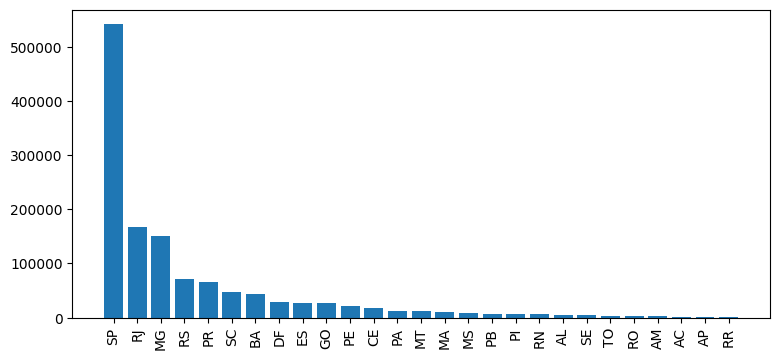

In [9]:
 query4=""" select count(customer_id) ,customer_state from customers
 group by customer_state"""
cur.execute(query4)

data4=cur.fetchall()
df=pd.DataFrame(data4,columns=["Numbers","State"])
df=df.sort_values(by = "Numbers",ascending=False)

plt.figure(figsize=(9,4))

plt.bar(df["State"],df["Numbers"])
plt.xticks(rotation=90)
plt.show()

#  Calculate the number of orders per month in 2018.


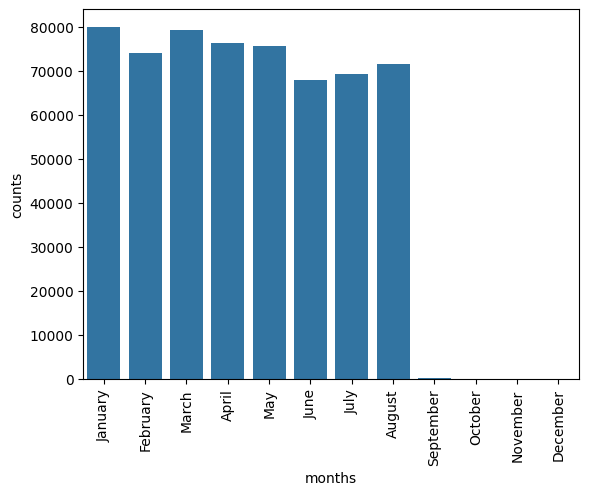

In [10]:
query5=""" select monthname(order_purchase_timestamp)  months,count(order_id) from 
orders where year(order_purchase_timestamp)=2018 group by months order by months asc """

cur.execute(query5)
data5=cur.fetchall()

df=pd.DataFrame(data5,columns=["months","counts"])
o=["January","February","March","April","May","June","July","August","September","October","November","December"]

sns.barplot(x=df["months"],y=df["counts"] ,data=df,order=o)
plt.xticks(rotation=90)
plt.show()

#  2. Find the average number of products per order, grouped by customer city.

In [11]:
query6="""
 with count_per_order as (select orders.order_id  ,orders.customer_id as customerid,count(order_items.order_id ) as counts from orders join  order_items 
on  orders.order_id=order_items.order_id group by orders.order_id,orders.customer_id )

select customers.customer_city as city ,avg(count_per_order.counts) from
customers join  count_per_order on customers.customer_id =count_per_order.customerid
group by city
"""

cur.execute(query6)
data6=cur.fetchall()

data6

[('treze tilias', Decimal('84.0000')),
 ('indaial', Decimal('73.6154')),
 ('sao jose dos campos', Decimal('75.1399')),
 ('sao paulo', Decimal('76.3101')),
 ('porto alegre', Decimal('77.5452')),
 ('santos', Decimal('76.6572')),
 ('sao francisco do sul', Decimal('81.5294')),
 ('sao vicente', Decimal('72.0000')),
 ('joinville', Decimal('72.7757')),
 ('sao vendelino', Decimal('66.0000')),
 ('belo horizonte', Decimal('75.4560')),
 ('bage', Decimal('69.1429')),
 ('gravatai', Decimal('70.1250')),
 ('sumare', Decimal('74.7514')),
 ('rio de janeiro', Decimal('75.6866')),
 ('navegantes', Decimal('76.6452')),
 ('chapada do norte', Decimal('66.0000')),
 ('frederico westphalen', Decimal('70.7143')),
 ('contagem', Decimal('75.5177')),
 ('curitiba', Decimal('76.5338')),
 ('guaranta', Decimal('66.0000')),
 ('miracema', Decimal('69.4737')),
 ('campo grande', Decimal('75.4286')),
 ('rodeio', Decimal('75.4286')),
 ('barueri', Decimal('73.6923')),
 ('urussanga', Decimal('66.0000')),
 ('osorio', Decimal('7

#  3. Calculate the percentage of total revenue contributed by each product category.

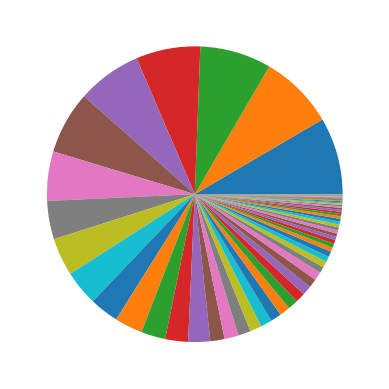

In [12]:
query7="""  select (products.product_category)as category ,round((sum( payments.payment_value)
 /(select sum(payment_value) from payments))* 100,2) as sales  from products join 
 order_items
 on products.product_id =order_items.product_id join payments 
 on payments.order_id = order_items.order_id group by category order by sales desc ; """

cur.execute(query7)
data7=cur.fetchall()
df=pd.DataFrame(data7,columns=["category","sales"])



plt.pie(df["sales"])
plt.show()





#  Identify the correlation between product price and the number of
# times a product has been purchased.

In [13]:
import numpy as np
query8=""" select products.product_category  category,
count(order_items.product_id) counts,round(avg(order_items.price),2) 
from products join order_items on
products.product_id=order_items.product_id
group by category  """ 

cur.execute(query8)

data8=cur.fetchall()

df=pd.DataFrame(data8,columns=["category","counts","avg"])


arr1=df["counts"]
arr2=df["avg"]
np.corrcoef([arr1,arr2])

array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

#  5. Calculate the total revenue generated by each seller, and rank them by revenue.

In [14]:
query9=""" select *,dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id as  sellers,sum(payments.payment_value) as revenue from 
order_items join payments on
order_items.order_id=payments.order_id 
group by sellers) as a """

cur.execute(query9)
data9=cur.fetchall()
df=pd.DataFrame(data9,columns=["seller_id","revenue","rank"] )
df


,seller_id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,1.825801e+07,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,1.109599e+07,2
2,4a3ca9315b744ce9f8e9374361493884,1.084483e+07,3
3,1f50f920176fa81dab994f9023523100,1.044912e+07,4
4,53243585a1d6dc2643021fd1853d8905,1.025651e+07,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,6.915600e+02,3082
3091,702835e4b785b67a084280efca355756,6.681600e+02,3083
3092,4965a7002cca77301c82d3f91b82e1a9,5.889600e+02,3084
3093,77128dec4bec4878c37ab7d6169d6f26,5.479200e+02,3085


# 1. Calculate the moving average of order values for each customer over their order history.

In [15]:
query10="""select customer_id,order_purchase_timestamp,payment,avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id ,orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id=orders.order_id) as a """

cur.execute(query10)
data10=cur.fetchall()
df=pd.DataFrame(data10)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
6856471,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
6856472,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
6856473,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
6856474,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# 2. Calculate the cumulative sales per month for each year.

In [16]:
query11 = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query11)
data11 = cur.fetchall()
df = pd.DataFrame(data11)
df


,0,1,2,3
0,2016,9,16647.84,1.664784e+04
1,2016,10,3899971.68,3.916620e+06
2,2016,12,1294.92,3.917914e+06
3,2017,1,9140210.64,1.305813e+07
4,2017,2,19265928.63,3.232405e+07
5,2017,3,29690997.57,6.201505e+07
6,2017,4,27574009.95,8.958906e+07
7,2017,5,39132642.13,1.287217e+08
8,2017,6,33744241.10,1.624659e+08
9,2017,7,39097272.69,2.015632e+08


# 3. Calculate the year-over-year growth rate of total sales.

In [17]:
query="""with a as(select year(orders.order_purchase_timestamp)as year ,
round(sum(payments.payment_value),2) as payment from
orders join payments on  orders.order_id=payments.order_id
group by year order by year)


select year,(payment-lag(payment,1) over(order by year)) /lag(payment,1) over(order by year) *100 from a """

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["years","%sales"])
df

,years,%sales
0,2016,NaN
1,2017,12112.703758
2,2018,20.000924


#  4. Calculate the retention rate of customers, defined as the percentage of 
# customers who make another purchase within 6 months of their first purchase.

In [23]:
query="""with a as( select customers.customer_id ,min(orders.order_purchase_timestamp) first_order from
customers join orders on
customers.customer_id=orders.customer_id
group by customers.customer_id),

b as(
select a.customer_id ,count(distinct orders.order_purchase_timestamp)
from a join orders 
on orders.customer_id =a.customer_id
and orders.order_purchase_timestamp > first_order 
and orders.order_purchase_timestamp < date_add(first_order,interval 6 month)
group by a.customer_id)

select 100* (count(distinct a.customer_id)/count(distinct b.customer_id) )
from a left join b 
on a.customer_id=b.customer_id
"""

cur.execute(query)
data=cur.fetchall()

df=pd.DataFrame(data)
df


,0
0,None
